In [47]:
# INSTALACIONES REQUERIDAS:
#%pip install antlr4-python3-runtime
#%pip install seaborn

In [48]:
# Todos los imports
import os
import re
import numpy as np
import pandas as pd
from antlr4 import *
import seaborn as sns
from itertools import product
from JavaLexer import JavaLexer
import matplotlib.pyplot as plt
from JavaParser import JavaParser
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, f1_score


In [49]:
# ConPlag dataset import
def loadConPlag(train_path, test_path, labels_path):
    # Cargar los pares de entrenamiento y prueba
    train_pairs = pd.read_csv(train_path, header=None, names=['pair'])
    test_pairs = pd.read_csv(test_path, header=None, names=['pair'])

    # Cargar las etiquetas
    labels = pd.read_csv(labels_path)
    labels['pair'] = labels['sub1'] + '_' + labels['sub2']

    # Unir las etiquetas con los pares de entrenamiento y prueba
    train_pairs = train_pairs.merge(labels[['pair', 'verdict']], on='pair', how='left')
    test_pairs = test_pairs.merge(labels[['pair', 'verdict']], on='pair', how='left')

    print(f"Total de codigos cargados: {len(train_pairs) + len(test_pairs)}")

    return train_pairs, test_pairs

# Cargar los datos
train_pairs, test_pairs = loadConPlag(
    '../datasets/ConPlag/versions/train_pairs.csv',
    '../datasets/ConPlag/versions/test_pairs.csv',
    '../datasets/ConPlag/versions/labels.csv'
)

# contar cuantos plagios y no plagios hay en total
total_plagios = train_pairs['verdict'].value_counts().get('plagio', 0)
total_no_plagios = train_pairs['verdict'].value_counts().get('no_plagio', 0)


# Mostrar los primeros registros
print(train_pairs.head())
print("Columnas del DataFrame después de la unión:", train_pairs.columns)

# Función para cargar el código de los pares
def load_code(submission_id):
    folder_name = submission_id
    code1_id, code2_id = folder_name.split('_')

    # Rutas de los archivos de código
    code1_path = f'../datasets/ConPlag/versions/version_2/{folder_name}/{code1_id}.java'
    code2_path = f'../datasets/ConPlag/versions/version_2/{folder_name}/{code2_id}.java'

    # Leer el contenido de los archivos
    with open(code1_path, 'r', encoding='utf-8') as file:
        code1 = file.read()
    with open(code2_path, 'r', encoding='utf-8') as file:
        code2 = file.read()

    

    return code1, code2

# Cargar los códigos correspondientes a todos los pares de entrenamiento y prueba en un solo dataset
def load_all_codes(train, test):
    all_codes = []
    for index, row in pd.concat([train, test]).iterrows():
        code1, code2 = load_code(row['pair'])
        all_codes.append({'code1': code1, 'code2': code2, 'verdict': row['verdict']})
    
    return pd.DataFrame(all_codes)

conPlagCodes = load_all_codes(train_pairs, test_pairs)
print (f"Total de códigos cargados en variable: {len(conPlagCodes)}")


Total de codigos cargados: 911
                pair  verdict
0  2470b521_f6ca6fc8        0
1  a8e2cefc_ee270b2a        0
2  90f01508_e00b1794        0
3  16857116_f3d7ce08        1
4  51151974_c23278ec        0
Columnas del DataFrame después de la unión: Index(['pair', 'verdict'], dtype='object')
Total de códigos cargados en variable: 911


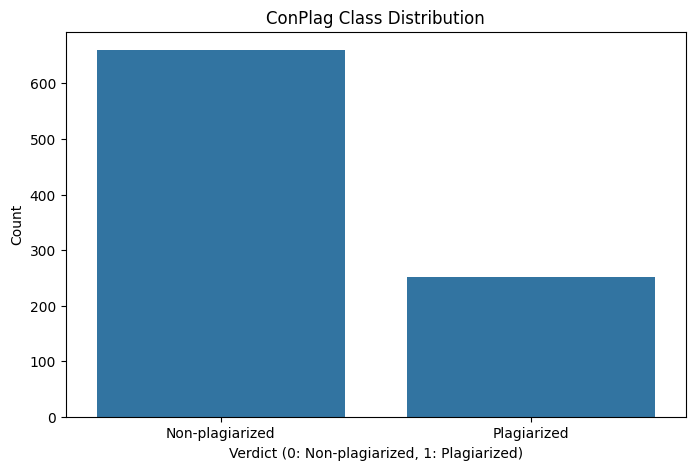

Total Plagiarized: 251 | Total Non-plagiarized: 660


In [50]:
def plot_conplag_distribution(df, title):
    total = train_pairs['verdict'].value_counts() + test_pairs['verdict'].value_counts()
    total = total.reindex([0, 1], fill_value=0)  # Asegurar que ambos valores estén presentes
    plt.figure(figsize=(8, 5))
    sns.barplot(x=total.index, y=total.values)
    plt.title(title)
    plt.xlabel('Verdict (0: Non-plagiarized, 1: Plagiarized)')
    plt.ylabel('Count')
    plt.xticks(ticks=[0, 1], labels=['Non-plagiarized', 'Plagiarized'])
    plt.show()
    print(f"Total Plagiarized: {total.get(1, 0)} | Total Non-plagiarized: {total.get(0, 0)}")
 

plot_conplag_distribution(conPlagCodes, 'ConPlag Class Distribution')

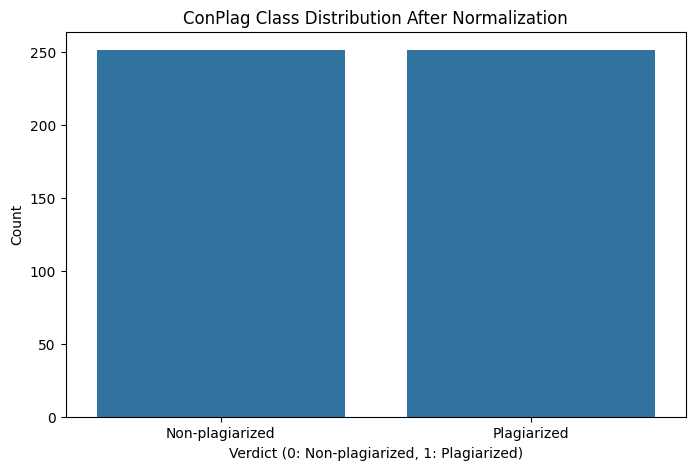

In [ ]:
# Normalicemos el dataset para que tenga un número equilibrado de plagios y no plagios
def normalize_counts(df):
    # Create a copy of the dataframe to avoid modifying the original
    df = df.copy()
    
    # Map string labels to binary values first
    df['verdict'] = df['verdict'].replace({'plagio': 1, 'no_plagio': 0})
    
    # Count the number of each class
    total_plagios = (df['verdict'] == 1).sum()
    total_no_plagios = (df['verdict'] == 0).sum()
    
    # Set target size (use minimum between 251 and the smallest class size)
    target_size = min(251, total_plagios, total_no_plagios)
    
    # Sample equal numbers from each class
    plagios = df[df['verdict'] == 1].sample(n=target_size, random_state=42)
    no_plagios = df[df['verdict'] == 0].sample(n=target_size, random_state=42)
    
    # Combine and shuffle
    df_balanced = pd.concat([plagios, no_plagios])
    df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)
    
    # Convert verdict back to string labels
    #     
    # Print statistics
    
    return df_balanced

conPlagCodes = normalize_counts(conPlagCodes)

# Mostrar la distribución de clases después de la normalización
plt.figure(figsize=(8, 5))
sns.countplot(x='verdict', data=conPlagCodes)
plt.title('ConPlag Class Distribution After Normalization')
plt.xlabel('Verdict (0: Non-plagiarized, 1: Plagiarized)')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Non-plagiarized', 'Plagiarized'])
plt.show()

In [52]:
# Configuración mejorada basada en Karnalim (2020) y Fu et al. (2017)
CRITICAL_TOKENS = {
    # Identificadores (conservamos tipo pero normalizamos nombres)
    'IDENTIFIER': lambda t: f'VAR_{t.text[0]}_{len(t.text)}',  # Ej: VAR_x_3
    
    # Literales
    'DECIMAL_LITERAL': lambda t: 'LIT_NUM',
    'STRING_LITERAL': lambda t: 'LIT_STR',
    
    # Operadores
    'EQUAL': lambda t: 'OP_=',
    'NOTEQUAL': lambda t: 'OP_!=',
    'LT': lambda t: 'OP_<',
    'GT': lambda t: 'OP_>',
    'ADD': lambda t: 'OP_+',
    'SUB': lambda t: 'OP_-',
    
    # Estructuras de control
    'IF': lambda t: 'CTRL_if',
    'FOR': lambda t: 'CTRL_for',
    'WHILE': lambda t: 'CTRL_while'
}

# Tokens a ignorar (basado en WASTK)
IGNORE_TOKENS = {
    ';', '(', ')', '[', ']', '{', '}', '@', 'import', 'package'
}

def tokenize_java(code):
    """Tokenizador mejorado con normalización selectiva"""
    input_stream = InputStream(code)
    lexer = JavaLexer(input_stream)
    stream = CommonTokenStream(lexer)
    stream.fill()
    
    tokens = []
    for token in stream.tokens:
        if token.channel != Lexer.DEFAULT_TOKEN_CHANNEL:
            continue
            
        token_name = lexer.symbolicNames[token.type]
        token_text = token.text.strip()
        
     
        if token_name in CRITICAL_TOKENS:
            processed = CRITICAL_TOKENS[token_name](token)
            tokens.append(processed)
        else:
            # Conservamos otros tokens relevantes
            if len(token_text) > 1:  # Ignorar caracteres sueltos
                tokens.append(token_text)
    
    return tokens


In [53]:
# TF-IDF function
def compute_tfidf_similarity(code1, code2):
    # Tokenizar y preprocesar los códigos
    tokens1 = tokenize_java(code1)
    tokens2 = tokenize_java(code2)

    # Vectorizar los códigos
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform([' '.join(tokens1), ' '.join(tokens2)])

    # Calcular la similitud coseno
    similarity = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:2])
    
    return similarity[0][0] 

conplag = compute_tfidf_similarity(conPlagCodes['code1'][0], conPlagCodes['code2'][0])

# Mostrar similitudes
print(f"Similitud ConPlag: {conplag:.4f}")


Similitud ConPlag: 0.7097


In [54]:

# Función mejorada para calcular similitudes para todos los pares
def calculate_all_similarities(pairs_df):
    similarities = []
    for idx, row in pairs_df.iterrows():
        try:
            sim = compute_tfidf_similarity(row['code1'], row['code2'])
            similarities.append(sim)
        except Exception as e:
            print(f"Error procesando par {row['pair']}: {str(e)}")
            similarities.append(0)
    return np.array(similarities)

Threshold óptimo: 0.72, F1-score: 0.79


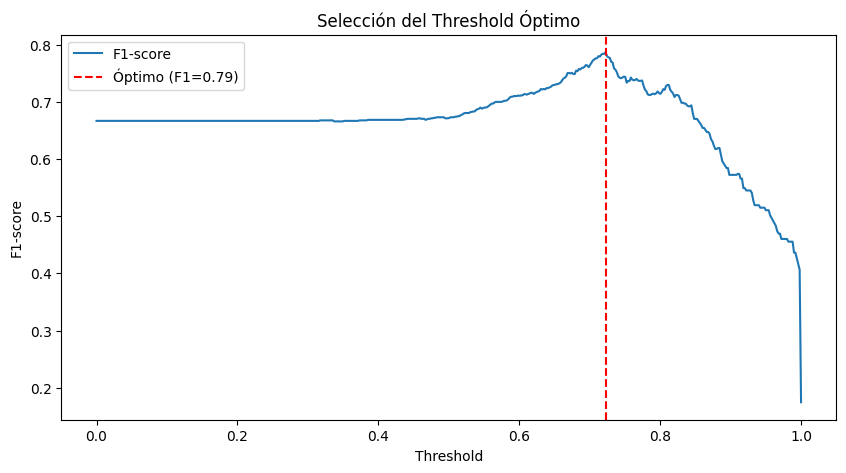

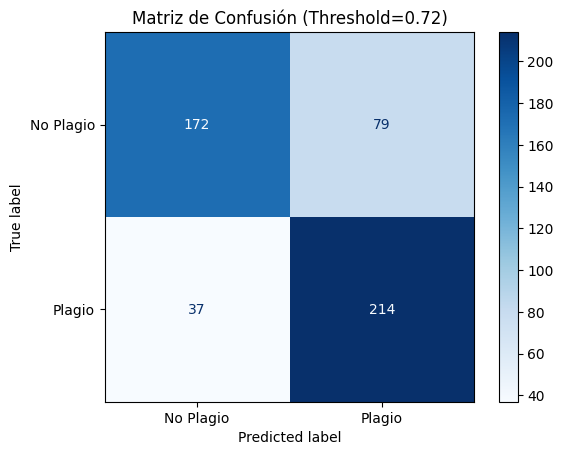

No Plagio: 209, Plagio: 293

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.82      0.69      0.75       251
           1       0.73      0.85      0.79       251

    accuracy                           0.77       502
   macro avg       0.78      0.77      0.77       502
weighted avg       0.78      0.77      0.77       502



In [59]:
# Calcular similitudes para ConPlag
conPlagCodes['similarity'] = calculate_all_similarities(conPlagCodes)

# Preparar etiquetas verdaderas (y_true)
y_true = conPlagCodes['verdict'].values


# Calcular threshold óptimo
thresholds = np.linspace(0.0, 1, len(conPlagCodes['similarity']))
f1_scores = [f1_score(y_true, conPlagCodes['similarity'] > t) for t in thresholds]
best_threshold = thresholds[np.argmax(f1_scores)]
best_f1 = max(f1_scores)

print(f"Threshold óptimo: {best_threshold:.2f}, F1-score: {best_f1:.2f}")

# Visualización
plt.figure(figsize=(10, 5))
plt.plot(thresholds, f1_scores, label='F1-score')
# Prueba de otros thresholds
#best_threshold = 0.67
plt.axvline(best_threshold, color='r', linestyle='--', label=f'Óptimo (F1={best_f1:.2f})')
plt.xlabel('Threshold')
plt.ylabel('F1-score')
plt.title('Selección del Threshold Óptimo')
plt.legend()
plt.show()




# Matriz de confusión con el threshold óptimo
#best_threshold = 0.78
y_pred = (conPlagCodes['similarity'] > best_threshold).astype(int)
ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=['No Plagio', 'Plagio'], 
                                        cmap=plt.cm.Blues) 
plt.title(f'Matriz de Confusión (Threshold={best_threshold:.2f})')
plt.show()

print(f'No Plagio: {np.sum(y_pred == 0)}, Plagio: {np.sum(y_pred == 1)}')

# Reporte de clasificación
print("\nReporte de Clasificación:")
print(classification_report(y_true, y_pred))

